## Importe de paquetes

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from collections import Counter
from datetime import datetime
from pyspark.sql import types as t
# from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Configuración

### Configuración de la sesion Spark

In [ ]:
path_jar_driver = '../mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

22/08/25 09:48:57 WARN Utils: Your hostname, Ricardos-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.2 instead (on interface en0)
22/08/25 09:48:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/08/25 09:48:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Configuración de la conexión a la BD

In [4]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_4_202214'
db_psswd = 'NT8ZK03Q4H'

PATH='./'

In [5]:
sql_movimientos = 'WWImportersTransactional.movimientosCopia'

## Cargue de datos

In [6]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

In [7]:
movimientos = obtener_dataframe_de_bd(db_connection_string, sql_movimientos, db_user, db_psswd)

In [8]:
movimientos.show(10)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

# Perfilamiento de los datos

El grupo de consultores de analitica descriptiva de Wide World Importers asegura que las tablas Grupo de compras, Ciudades, Colores, Paises, Clientes, Categorias de clientes, Paquetes, Estados y provincias, Productos y Personas ya fueron perfiladas y corregidos; sin embargo le recomiendan revisar el diccionario suministrado dado que todas las tablas serán utilizadas en futuros requerimientos.
Si tienen alguna duda relacionada con estas tablas deben incluirla en las preguntas o aclaraciones que le entreguen a la organización como parte del resultado de esta fase de entendimiento.

En este punto de la consultorìa, nuestra responsabilidad es analizar la tabla movimientosCopia, que registra el movimiento en inventario de un producto. La empresa no compartió información de las tablas de clientes ni de proveedores para esta actividad. Con respecto a esta fuente nos comentan lo siguiente:

- La cantidad máxima de productos movidos es 50 millones por transacción
- Existen 236.668 movimientos de producto realizados desde 2013
- Los movimientos están relacionados con 228.265 clientes
- El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
- Actualmente tenemos 13 proveedores


## ¿Cuantos datos nos compartieron para el proyecto?

In [9]:
print(f"registros = {movimientos.count()}", f"columnas = {len(movimientos.columns)}")

registros = 204292 columnas = 9


In [10]:
movimientos.schema

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true)))

In [11]:
Counter([col[1] for col in movimientos.dtypes])

Counter({'int': 3, 'double': 3, 'string': 3})

En total tenemos 204.292 movimientos y tenemos en total 9 variables a revisar de las cuales 6 son nùmericas y las demás son cadenas de caracteres. Vale la pena aclarar que 7 variables son IDs.

## ¿Qué es una fila de cada fuente compartida?

In [12]:
movimientos.where(movimientos['TransaccionProductoID'] == 197005).show()

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               197005|        80|               11|      0.0|      0.0|        4.0|         1272.0|     Feb 10,2015| 11148.0|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+



En este caso un registro en específico representa un movimiento (transacción) que ha realizado un cliente con un producto específico. Cada movimiento cunta con identificadores únicos que detallan el producto, el tipo de transacción, el cliente, la factura, el proveedor y la orden de compra. Tambien indica la fecha en la que se ejecutó y la cantidad de productos del mismo tipo que se compraron para ese movimiento.

## Análisis descriptivo

In [13]:
movimientos.summary().show()

+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|summary|TransaccionProductoID|        ProductoID|  TipoTransaccionID|         ClienteID|        InvoiceID|      ProveedorID|   OrdenDeCompraID|    FechaTransaccion|         Cantidad|
+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|  count|               204292|            204292|             204292|            204292|           204292|           204292|            204292|              204292|           204292|
|   mean|   212458.04047637695|110.70090850351458| 10.035253460732676| 517.3252941867523|42957.26929590978|4.951898734177215|1345.9973277074544|                null|719.4997650421946|
| stddev|    71352.37579752573| 63.49014746219581|0.18563716955046372|353.501369

El calculo de la media para las columnas ID, esto se hace automatico pues son columnas cuyo tipo de dato es numerico, sin embargo estas no son variables numericas por lo cual calcular y/o analizar la media no tiene sentido. La lógica es similar para los otros estadísticos.

En las estadíticas de Cantidad podemos observar que el valor promedio es 719.500, pero su desviación estandar es muy elevada (4729.367) por lo que se puede notar una gran dispersion en los datos.


{'whiskers': [<matplotlib.lines.Line2D at 0x11d9667f0>,
 'caps': [<matplotlib.lines.Line2D at 0x11d966e50>,
 'boxes': [<matplotlib.lines.Line2D at 0x11d966520>],
 'medians': [<matplotlib.lines.Line2D at 0x11d8334c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x11d8e3fa0>],
 'means': []}

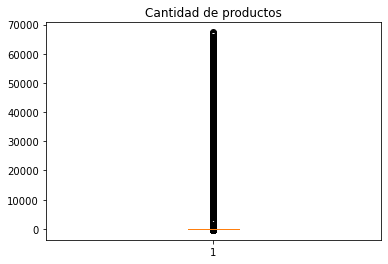

In [14]:
fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad de productos')
ax1.boxplot(np.array(movimientos.select('Cantidad').collect()))

array([[<AxesSubplot:title={'center':'Cantidad'}>]], dtype=object)

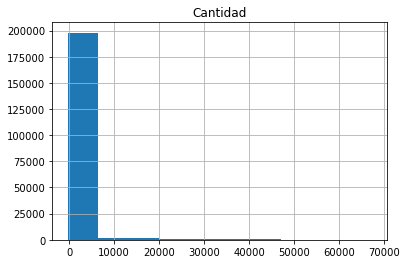

In [15]:
movimientos.toPandas().hist(column='Cantidad')

De los graficos anteriores podemos evidenciar la gran cantiidad de datos atipicos y la dispersion en la  variable Cantidad. Así mismo, evidenciamos desde ya un posible error en los datos pues hay cantidades negativas.

In [16]:
movimientos.groupby("FechaTransaccion").count().orderBy("count", ascending=False).show(5)

+--------------------+-----+
|    FechaTransaccion|count|
+--------------------+-----+
|2015-11-03 12:00:...|  331|
|2015-01-21 12:00:...|  326|
|2015-04-14 12:00:...|  323|
|2016-05-04 12:00:...|  323|
|2015-10-06 12:00:...|  317|
+--------------------+-----+
only showing top 5 rows



Vemos que la inmesa mayoria de movimientos se hicieron en 2015.

# Análisis de calidad de datos

## Completitud

In [17]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados


In [18]:
contar_vacios(movimientos)

[]

Podemos ver que no hay datos vacíos en la tabla movimientosCopia.

In [19]:
def contar_blancos(df):
    resultados = []
    for c in df.columns:
        vacios = df.where(df[c] == '').count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados


In [20]:
contar_blancos(movimientos)

número de vacíos para columna ProveedorID: 197182


número de vacíos para columna OrdenDeCompraID: 197182


[197182, 197182]

Pero igualmente podemos notar que hay 197.182 registros cuyo ProveedorID y OrdenDeCompraID es un espacio en blanco. Lo que se puede considerar un claro problema a la completitud de los datos.

In [21]:
def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado


In [22]:
columnas_alta_cardinalidad_movimientos = cardinalidad(movimientos)
columnas_alta_cardinalidad_movimientos

{'TransaccionProductoID': 173659}

Respecto a cardinalidad, solo la columna TransaccionProductoID tiene una cardinalidad superior al 50%.

## Unicidad

In [23]:
print(f"registros = {movimientos.count()}", f"registros distintos = {movimientos.distinct().count()}", f"registros repetidos = {movimientos.count() - movimientos.distinct().count()}")

registros = 204292 registros distintos = 173659 registros repetidos = 30633


Como pueden ver hay 173.659 registros de movimientoos que son unicos, lo que implica que 30.633 movimientos son completamente repetidas.

In [24]:
movimientos.select(col('TransaccionProductoID')).distinct().count()

173659

De esta manera vemos que no hay  diferencia entre el numero de registros y el numero de registros cuyo identificador es unico.

## Consistencia
A nivel de consistencia algunos ejemplos de revisión son precios negativos, productos que aparecen en las ordenes pero que no esten registrados en la tabla de produtos. En nuestro caso vamos a verificar que todas las ordenes tengan detalle de orden y viceversa

In [26]:
TransaccionProductoIDS = set([x.TransaccionProductoID for x in movimientos.select('TransaccionProductoID').collect()])
ProveedorIDS = set([x.ProveedorID for x in movimientos.select('ProveedorID').collect()])
OrdenDeCompraIDS = set([x.OrdenDeCompraID for x in movimientos.select('OrdenDeCompraID').collect()])

[len(TransaccionProductoIDS-ProveedorIDS), len(TransaccionProductoIDS-OrdenDeCompraIDS)], [len(ProveedorIDS-TransaccionProductoIDS), len(OrdenDeCompraIDS-TransaccionProductoIDS)]

([173659, 173659], [4, 1472])

Como se puede observar hay una diferencia de 173.659 movimientos que no tienen ProveedorID ni OrdenDeCompraID y hay 4  proveedores que no tienen un movimiento asociado, asi como 1.472 ordenes de compra sin algun movimiento. Ninguno de los casos tiene sentido en el contexto de WideWorldImporters.

## Validez    

In [27]:
CantidadNegativa = [x.Cantidad for x in movimientos.select('Cantidad').collect() if x.Cantidad < 0]
len(CantidadNegativa)

197158

Ya  evidenciamos varios problemas de validez en las  secciones de unicidad y de completitud. Ahora bien, tenemos que hay 197.158 cantidades negativas lo que es un absurdo, la vble cantidad no deberia almacenar numeros menores que cero.

# Conclusiones/resultados

## ¿Es posible resolver los análisis basados en tableros de control propuestos?

In [28]:
data = movimientos.where((movimientos['ProveedorID'] != '') & (movimientos['OrdenDeCompraID'] != '') & (movimientos['Cantidad'] > 0))
data.show(5)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               197005|        80|               11|      0.0|      0.0|        4.0|         1272.0|     Feb 10,2015| 11148.0|
|               111093|        95|               11|      0.0|      0.0|        4.0|          745.0|     Mar 27,2014|  7764.0|
|               329831|       193|               11|      0.0|      0.0|        7.0|         2040.0|     May 11,2016| 65520.0|
|               169041|       184|               11|      0.0|      0.0|        7.0|         1100.0|     Oct 29,2014|  8775.0|
|               227339|        98|               11|      0.0|      0.0|        4.0|         1442.0|     May 22

In [29]:
data.count()

7110

In [30]:
print(f"porcentajen datos aptos = {(data.count()/movimientos.count())*100}")

porcentajen datos aptos = 3.4803124938813075


La cantidad de datos optimos para hacer el tablero es de 7.110, lo que implica que el analisis se realizaria sobre el 3.4% de los datos entregados. Siendo esta una muestra muy corta y poco representativa, concluyo que no es recomendable hacer el analisis basado en el tablero de control.

## ¿Que representa la fila promedio de los datos analizados?

En este caso un registro en específico representa un movimiento (transacción) que ha realizado un cliente con un producto específico. Cada movimiento cunta con identificadores únicos que detallan el producto, el tipo de transacción, el cliente, la factura, el proveedor y la orden de compra. Tambien indica la fecha en la que se ejecutó y la cantidad de productos del mismo tipo que se compraron para ese movimiento.